In [14]:
import os, sys
cwd = os.getcwd()

api_path_sampling = os.path.join(cwd, '..', 'tools', 'sampling_utils')
api_path_gan_metrics = os.path.join(cwd, '..', 'tools', 'gan_metrics')

sys.path.append(api_path_sampling)
sys.path.append(api_path_gan_metrics)

import os
import re
from typing import List, Optional

import click
import numpy as np
import PIL.Image
import torch
import random
from functools import partial

from matplotlib import pyplot as plt

from mh_sampling import mh_sampling
from ebm_sampling import (langevin_sampling, 
                          aggregate_sampling_output,
                          load_data_from_batches,
                          mala_sampling,
                          tempered_transitions_sampling,
                          gan_energy,
                          gan_energy_stylegan2_ada)
from general_utils import to_var, to_np
import time
from metrics import inception_score

import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

from fid_score import calculate_fid_given_paths


In [13]:
import torch
use_gpu = True if torch.cuda.is_available() else False

# trained on high-quality celebrity faces "celebA" dataset
# this model outputs 512 x 512 pixel images
model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub',
                       'PGAN', model_name='celebAHQ-512',
                       pretrained=True, useGPU=use_gpu)

Using cache found in /home/daniil/.cache/torch/hub/facebookresearch_pytorch_GAN_zoo_hub


Average network found !


In [3]:
device = torch.device('cuda:1')
D = model.getOriginalD()
G = model.getOriginalG()
G = G.eval().requires_grad_(False).to(device)
D = D.eval().requires_grad_(False).to(device)

In [18]:
num_images = 32
noise, _ = model.buildNoiseData(num_images)
noise = noise.to(device)
generated_images = G(noise)

In [19]:
generated_images.min()

tensor(-1.8346, device='cuda:1')

In [20]:
generated_images.max()

tensor(2.0412, device='cuda:1')

In [21]:
generated_images.shape

torch.Size([32, 3, 512, 512])

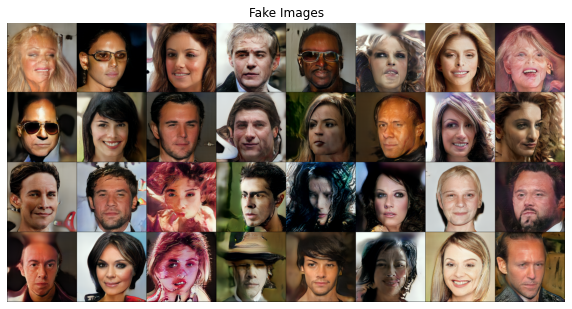

In [7]:
import matplotlib.pyplot as plt
import torchvision
grid = torchvision.utils.make_grid(generated_images.clamp(min=-1, max=1), scale_each=True, normalize=True)
plt.figure(figsize=(10, 10))
plt.title("Fake Images")
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()

In [76]:
dataroot = '/home/daniil/gans-mcmc/celeba/celeba_images'
image_size = 512
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
workers = 2
batch_size = 100
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

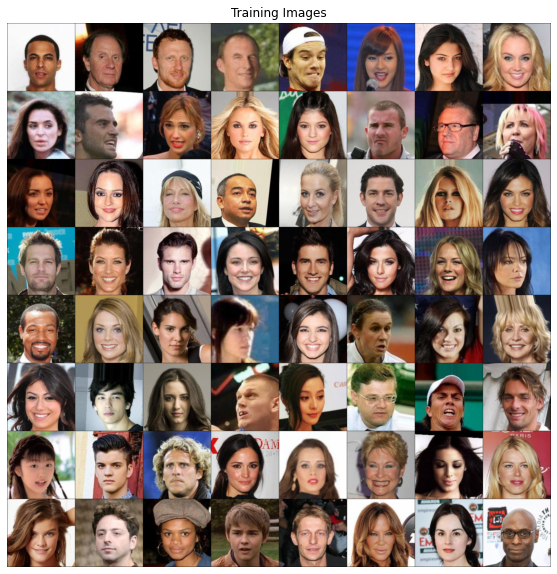

In [77]:
real_batch = next(iter(dataloader))
real_images = real_batch[0].to(device)[:64]
plt.figure(figsize=(10, 10))
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_images, 
                                         padding=2, normalize=True).cpu(),
                        (1,2,0))
          )
plt.axis("off")
plt.show()

In [78]:
real_images.min()

tensor(-1., device='cuda:1')

In [79]:
real_images.max()

tensor(1., device='cuda:1')

In [15]:
real_images.shape

torch.Size([64, 3, 512, 512])

In [4]:
class LatentFixDatasetCeleba(torch.utils.data.Dataset):
    """Dataset for Generator
    """
    def __init__(self, latent_arr, G, device, nsamples):
        self.latent_arr = latent_arr
        self.G = G
        self.nsamples = nsamples
        self.transform=transforms.Compose([
            transforms.ToTensor()
        ])
        self.device = device

    def __getitem__(self, index):
        z = to_var(self.latent_arr[index].unsqueeze(0), self.device)
        with torch.no_grad():
            image = self.G(z)
        clamp_image = self.clamp(G(z).permute(0, 2, 3, 1))
        np_image = to_np(clamp_image)
        squeeze_image = np.squeeze(np_image)
        
        return self.transform(squeeze_image)

    def __len__(self):
        return self.nsamples

    def clamp(self, x):
        # For fake data generated with tanh(x)
        return (x.clamp(-1, 1) + 1.)/2.

In [5]:
nsamples = 50000
noise, _ = model.buildNoiseData(nsamples)
latent_dataset = LatentFixDatasetCeleba(noise, G, 
                                        device, nsamples)

In [6]:
start = time.time()
batch_size = 64
(inception_score_mean, 
 inception_score_std) = inception_score(latent_dataset, 
                                        device, 
                                        batch_size, True)
consumed_time = time.time() - start



Start to make predictions
Start to compute KL divergence


In [7]:
consumed_time


1632.5388934612274

In [9]:
inception_score_mean

3.0295146421481105

In [10]:
inception_score_std

0.01321523786761441

In [ ]:
def save_images_for_fid_fix_latent(G,
                                   real_dataloader,
                                   name_fake_test,
                                   name_real_test,
                                   latent_arr,
                                   device,
                                   random_seed):
    fake_list = []
    real_list = []
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    random.seed(random_seed)
    
    max_num_imgs = latent_arr.shape[0]
    start_ind = 0

    for  i, data_real in enumerate(real_dataloader, 0):
        batch_real = data_real[0]
        batch_size = batch_real.shape[0]
        
        if (start_ind + batch_size <= max_num_imgs):
            fixed_noise = latent_arr[start_ind:start_ind + batch_size].to(device)
            fake_images = G(fixed_noise).clamp(-1, 1)
            start_ind += batch_size
            
            fake_norm_np = ((1. + fake_images)/2).detach().cpu().numpy()
            real_norm_np = ((1. + batch_real)/2).detach().cpu().numpy()
            fake_list.append(fake_norm_np)
            real_list.append(real_norm_np)
            
        else:
            fixed_noise = latent_arr[start_ind:].to(device)
            fake_images = G(fixed_noise).clamp(-1, 1)
            add_num_imgs = max_num_imgs - start_ind
            batch_real = batch_real[:add_num_imgs]
            
            fake_norm_np = ((1. + fake_images)/2).detach().cpu().numpy()
            real_norm_np = ((1. + batch_real)/2).detach().cpu().numpy()
            fake_list.append(fake_norm_np)
            real_list.append(real_norm_np)
            break 

    fake_np = np.concatenate(fake_list)
    real_np = np.concatenate(real_list)
    
    print(f"shape of generated images = {fake_np.shape}")
    print(f"shape of real images = {real_np.shape}")

    np.save(name_fake_test, fake_np)
    np.save(name_real_test, real_np)